<a href="https://colab.research.google.com/github/Martinszy007/JPX_Tokyo_Stock_Exchange_Prediction/blob/martins/MartinsEDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Introduction

Exploratory data analysis is a great way of understanding and analyzing the data sets. EDA technique is extensively used in this notebook to summarize the main characteristics of data sets and to visualize them through different graphs and plots.

## Objectives 
* To predict stock price by examining the trend & price movement for viability of potential investment.

#### Importation of all relevant pakages & Data

In [1]:
#Importing necessary packages

import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import seaborn as sns
import tqdm
import random
from scipy.optimize import minimize, Bounds, LinearConstraint, linprog
import base64
from io import BytesIO

!pip install -q mplfinance

import mplfinance as mpl

from ipywidgets import HTML



# Turn off the max column width so the images won't be truncated
pd.set_option('display.max_colwidth', None)
 
# Turning off the max column will display all the data
# if gathering into sets / array we might want to restrict to a few items
pd.set_option('display.max_seq_items', 3)

from multiprocessing import Pool, cpu_count

import warnings
warnings.simplefilter("ignore")


# Parallel df groupby func
def applyParallel(dfGrouped, func):
    with Pool(cpu_count()) as p:
        ret_list = p.map(func, [group for name, group in dfGrouped])
    return pd.concat(ret_list)



# Utility function
def sparkline(data, isBar=False, figsize=(7, 0.75), **kwargs):
    """
    creates a sparkline charts
    """
    data = list(data)
    
    *_, ax = plt.subplots(1, 1, figsize=figsize, **kwargs)
    if isBar:
        ax.bar(list(range(len(data))),data)
    else:
        c= 'green' if data[-1]> data[1] else 'red'
        ax.plot(data, color = c)
        ax.fill_between(range(len(data)), data, len(data)*[min(data)], alpha=0.1, color=c)
    ax.set_axis_off()
    plt.margins(0)

    img = BytesIO()
    plt.savefig(img, pad_inches = 0,bbox_inches= 'tight')
    img.seek(0)
    plt.close()
    return '<img src="data:image/png;base64,{}"/>'.format(base64.b64encode(img.read()).decode())

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### Merging the stock_prices & stock_list dataframe

In [3]:
df = pd.read_csv('/content/drive/MyDrive/JPX_Tokyo_Stock_Exchange_Prediction/data/train_files/stock_prices.csv',
                 parse_dates=['Date'])\
        .drop('RowId', axis= 1).merge(
            pd.read_csv('/content/drive/MyDrive/JPX_Tokyo_Stock_Exchange_Prediction/data/train_files/stock_list.csv')[['SecuritiesCode', 'Name', '33SectorName', '17SectorName', 'IssuedShares', 'MarketCapitalization']],
            on = 'SecuritiesCode', how = 'left')

df.set_index('Date', inplace= True)

df.head()

,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target,Name,33SectorName,17SectorName,IssuedShares,MarketCapitalization
Date,,,,,,,,,,,,,,,
2017-01-04,1301,2734.0,2755.0,2730.0,2742.0,31400,1.0,NaN,False,0.000730,"KYOKUYO CO.,LTD.","Fishery, Agriculture and Forestry",FOODS,10928283.0,3.365911e+10
2017-01-04,1332,568.0,576.0,563.0,571.0,2798500,1.0,NaN,False,0.012324,"Nippon Suisan Kaisha,Ltd.","Fishery, Agriculture and Forestry",FOODS,312430277.0,1.696496e+11
2017-01-04,1333,3150.0,3210.0,3140.0,3210.0,270800,1.0,NaN,False,0.006154,Maruha Nichiro Corporation,"Fishery, Agriculture and Forestry",FOODS,52656910.0,1.266399e+11
2017-01-04,1376,1510.0,1550.0,1510.0,1550.0,11300,1.0,NaN,False,0.011053,"KANEKO SEEDS CO.,LTD.","Fishery, Agriculture and Forestry",FOODS,11772626.0,1.770603e+10
2017-01-04,1377,3270.0,3350.0,3270.0,3330.0,150800,1.0,NaN,False,0.003026,SAKATA SEED CORPORATION,"Fishery, Agriculture and Forestry",FOODS,47410750.0,1.557443e+11


In [4]:
df.shape

(2332531, 15)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2332531 entries, 2017-01-04 to 2021-12-03
Data columns (total 15 columns):
 #   Column                Dtype  
---  ------                -----  
 0   SecuritiesCode        int64  
 1   Open                  float64
 2   High                  float64
 3   Low                   float64
 4   Close                 float64
 5   Volume                int64  
 6   AdjustmentFactor      float64
 7   ExpectedDividend      float64
 8   SupervisionFlag       bool   
 9   Target                float64
 10  Name                  object 
 11  33SectorName          object 
 12  17SectorName          object 
 13  IssuedShares          float64
 14  MarketCapitalization  float64
dtypes: bool(1), float64(9), int64(2), object(3)
memory usage: 269.2+ MB


In [6]:
df.describe()

,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,Target,IssuedShares,MarketCapitalization
count,2.332531e+06,2.324923e+06,2.324923e+06,2.324923e+06,2.324923e+06,2.332531e+06,2.332531e+06,18865.000000,2.332293e+06,2.332531e+06,2.332531e+06
mean,5.894835e+03,2.594511e+03,2.626540e+03,2.561227e+03,2.594023e+03,6.919366e+05,1.000508e+00,22.017730,4.450964e-04,1.557134e+08,3.793967e+11
std,2.404161e+03,3.577192e+03,3.619363e+03,3.533494e+03,3.576538e+03,3.911256e+06,6.773040e-02,29.882453,2.339879e-02,6.108806e+08,1.378945e+12
min,1.301000e+03,1.400000e+01,1.500000e+01,1.300000e+01,1.400000e+01,0.000000e+00,1.000000e-01,0.000000,-5.785414e-01,7.800000e+05,1.454124e+10
25%,3.891000e+03,1.022000e+03,1.035000e+03,1.009000e+03,1.022000e+03,3.030000e+04,1.000000e+00,5.000000,-1.049869e-02,1.958800e+07,2.864180e+10
50%,6.238000e+03,1.812000e+03,1.834000e+03,1.790000e+03,1.811000e+03,1.071000e+05,1.000000e+00,15.000000,0.000000e+00,3.929336e+07,6.092634e+10
75%,7.965000e+03,3.030000e+03,3.070000e+03,2.995000e+03,3.030000e+03,4.021000e+05,1.000000e+00,30.000000,1.053159e-02,9.814550e+07,1.936220e+11
max,9.997000e+03,1.099500e+05,1.105000e+05,1.072000e+05,1.095500e+05,6.436540e+08,2.000000e+01,1070.000000,1.119512e+00,1.631499e+10,3.435121e+13


#### JPX Tokyo Stock Market

HTML(value='<h3>Top Gaining Targets</h3>')

,Name,70_D_Close,Close,70_D_Volume,Target
SecuritiesCode,,,,,
4699,"UCHIDA ESCO CO.,Ltd.",,2160.00,,0.19
1873,"NIHON HOUSE HOLDINGS CO.,LTD.",,352.00,,0.19
6779,"NIHON DEMPA KOGYO CO.,LTD.",,1546.00,,0.16
7809,"KOTOBUKIYA CO.,LTD.",,6410.00,,0.14
3031,"RACCOON HOLDINGS,Inc.",,1155.00,,0.12
2489,Adways Inc.,,855.00,,0.11
6182,MetaReal Corporation,,1115.00,,0.11
7685,"BuySell Technologies Co.,Ltd.",,3750.00,,0.10
4490,VisasQ Inc.,,5520.00,,0.09

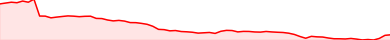
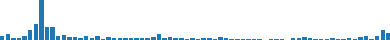
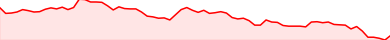
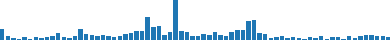
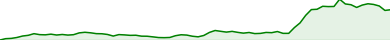
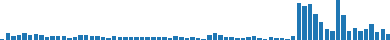
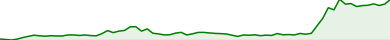
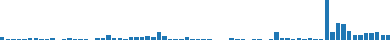
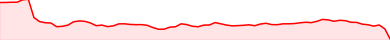
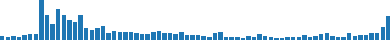
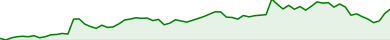
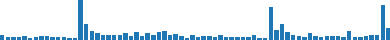
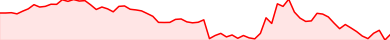
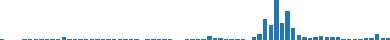
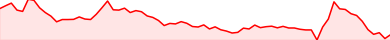
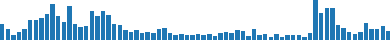
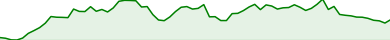
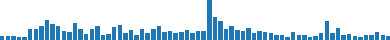
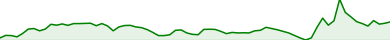
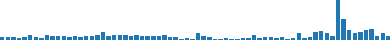

HTML(value='<h3>Top Loosing Targets</h3>')

,Name,70_D_Close,Close,70_D_Volume,Target
SecuritiesCode,,,,,
9919,KANSAI SUPER MARKET LTD.,,1829.00,,-0.22
6718,"AIPHONE CO.,LTD.",,2194.00,,-0.09
2158,"FRONTEO,Inc.",,2365.00,,-0.09
9790,"Fukui Computer Holdings,Inc.",,3860.00,,-0.08
6958,CMK CORPORATION,,514.00,,-0.06
1332,"Nippon Suisan Kaisha,Ltd.",,585.00,,-0.06
6620,"Miyakoshi Holdings,Inc.",,1219.00,,-0.06
2987,TASUKI Corporation,,3460.00,,-0.05
8278,"FUJI CO.,LTD.",,1965.00,,-0.05

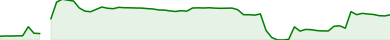
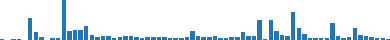
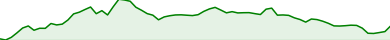
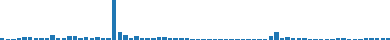
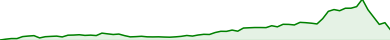
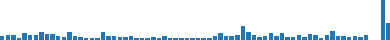
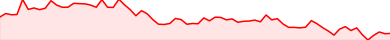
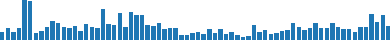
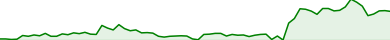
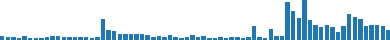
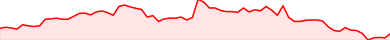
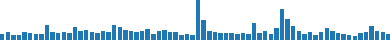
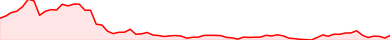
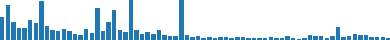
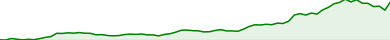
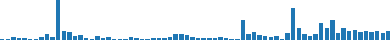
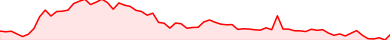
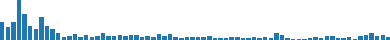
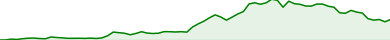
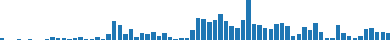

In [7]:
def show_table(df= df, date= '2021-12-03', sort_by= 'Target', asc= False, num_of_rows=10):
    
    # get data in between the date range
    a = df[df.index.isin(np.sort(df.index[df.index <= '2021-12-03'].unique())[-70:])]\
        .groupby('SecuritiesCode').agg(
            Name= pd.NamedAgg(column= 'Name', aggfunc='last'),
            Close= pd.NamedAgg('Close','last'),
            Target= pd.NamedAgg('Target', 'last'),
            Close_list= pd.NamedAgg('Close', pd.Series.tolist),
            Volume_list= pd.NamedAgg('Volume', pd.Series.tolist))\
        .sort_values(sort_by, ascending= asc).iloc[:num_of_rows]
    
    # add close line chart
    a['70_D_Close'] = a['Close_list'].apply(sparkline)
    
    # add volume bar chart
    a['70_D_Volume'] = a['Volume_list'].apply(lambda x: sparkline(x, isBar=True))
    
    
    return display(
        a[['Name', '70_D_Close', 'Close', '70_D_Volume', 'Target']]\
            .style.bar(subset=['Target'], align= 'zero', color= '#C0C0C0')\
            .set_properties(subset=['70_D_Close', '70_D_Volume'], **{'width': '250px'})\
            .set_properties(subset=['Name'], **{'width': '200px'})\
            .format('{:.2f}', subset= ['Close', 'Target']))


display(HTML('<h3>Top Gaining Targets</h3>'))
show_table(asc= False)

display(HTML('<h3>Top Loosing Targets</h3>'))
show_table(asc= True)

#### Sectors
Below we can See a crisp summary of sector-wise action happening across

* Target
* Turover: (close* volume) Volume measures the number of shares traded in a stock. Volume can indicate market strength.
* Market Capitalization: Market capitalization, commonly called market cap, is the market value of a publicly traded company's outstanding shares.

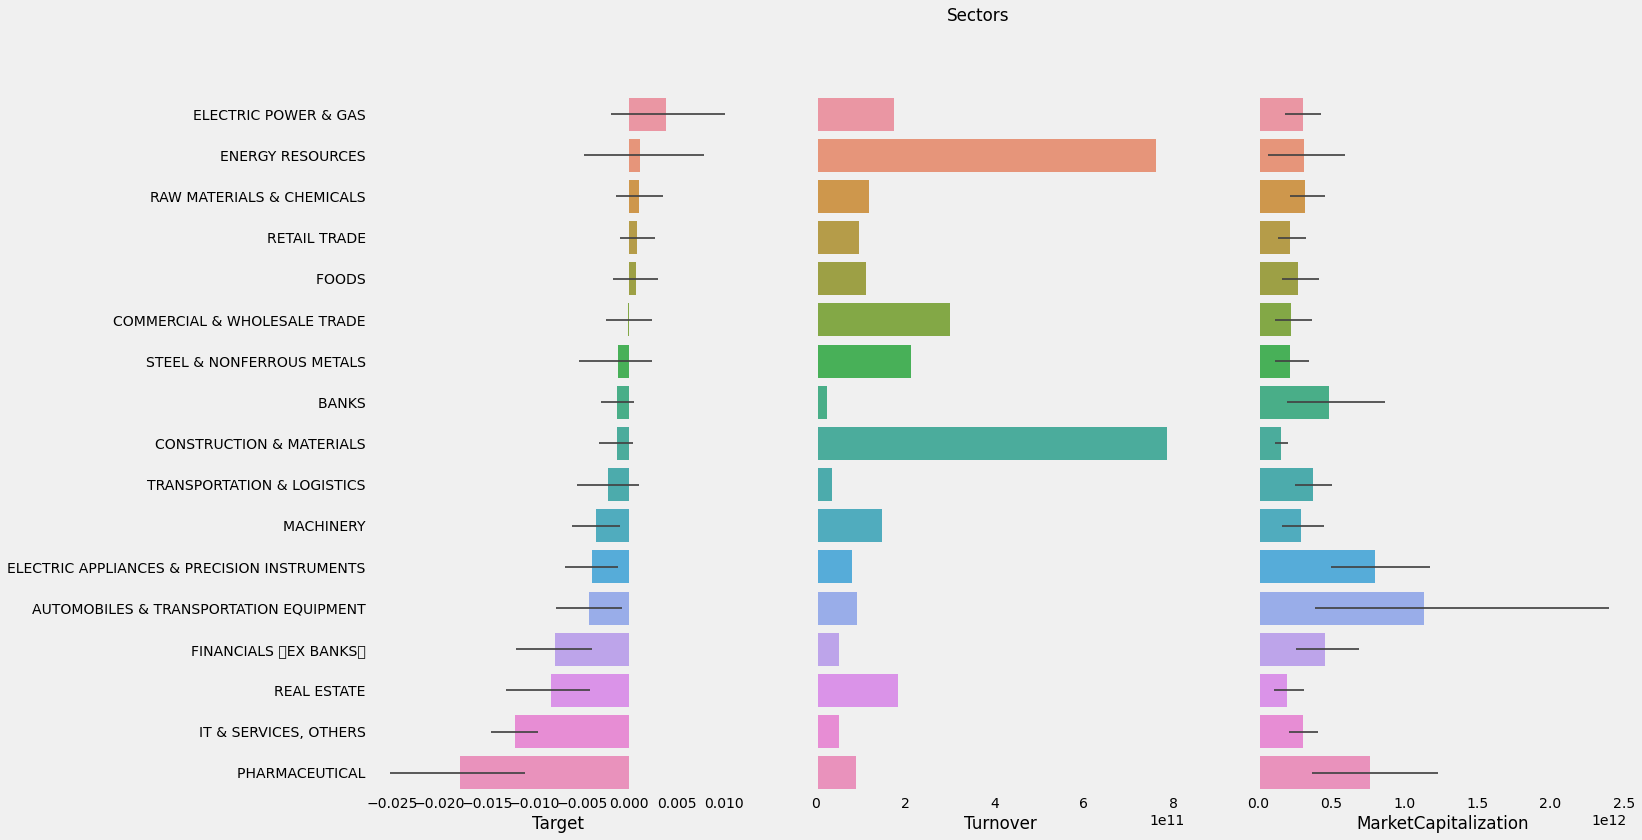

In [8]:
plt.style.use('fivethirtyeight')

fig, ax = plt.subplots(1,3, figsize=(20,12), sharey=True)
a = df.loc[df.index=='2021-12-02']
a['Turnover']= a.Close* a.Volume

sns.barplot(
    x='Target',
    y='17SectorName',
    data=a, ax=ax[0],
    errwidth=1.7,
    order= a.groupby('17SectorName').Target.mean().sort_values(ascending=False).index)

sns.barplot(
    x='Turnover',
    y='17SectorName',
    data=a, ax=ax[1],
    estimator= np.sum,
    ci=None,
    errwidth=1.7,
    order= a.groupby('17SectorName').MarketCapitalization.mean().sort_values(ascending=False).index)

sns.barplot(
    x='MarketCapitalization',
    y='17SectorName',
    data=a, ax=ax[2],
    #estimator= np.sum,
    #ci=None,
    errwidth=1.7,
    order= a.groupby('17SectorName').Target.mean().sort_values(ascending=False).index)


for i in ax:
    i.grid(False)
    i.set(ylabel=None)

fig.suptitle('Sectors')
fig.show()

#### Securities per Sector


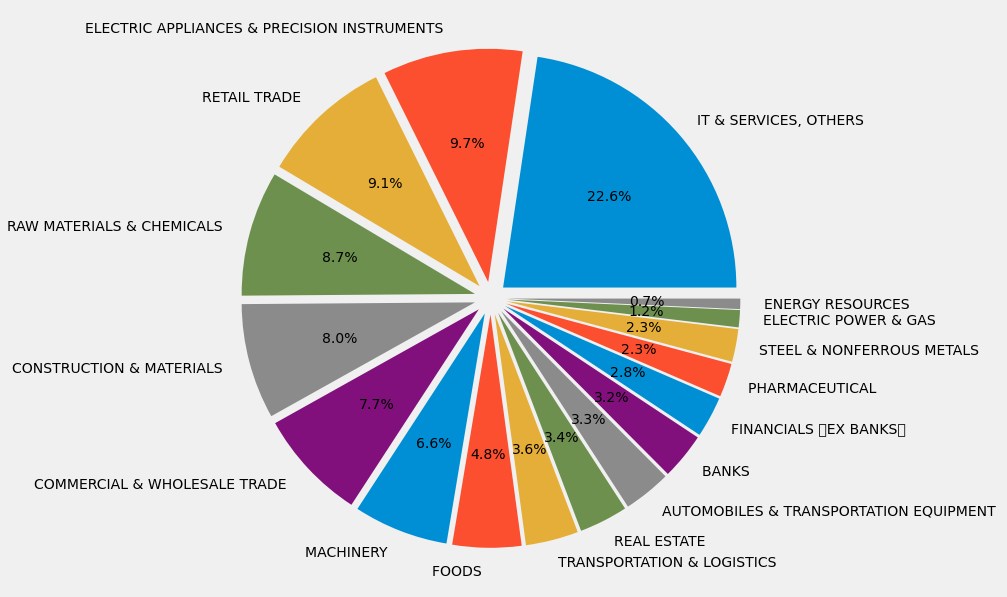

In [9]:
df['17SectorName'].value_counts().plot.pie(
    explode = [0.07 for i in range(17)],
    autopct='%1.1f%%',
    ylabel='',
    figsize=(20,10))


plt.show()

#### AUTOMOBILES & TRANSPORTATION EQUIPMENT Sector
AUTOMOBILES & TRANSPORTATION EQUIPMENT contribute Highest MarketCap in JPX markets. So we See all the stocks ups/downs in AUTOMOBILES & TRANSPORTATION EQUIPMENT sector..

,Name,70_D_Close,Close,70_D_Volume,Target
SecuritiesCode,,,,,
7408,JAMCO CORPORATION,,853.00,,0.06
7254,UNIVANCE CORPORATION,,477.00,,0.06
7220,"MUSASHI SEIMITSU INDUSTRY CO.,LTD.",,1823.00,,0.05
7105,"Mitsubishi Logisnext Co.,Ltd.",,1141.00,,0.05
5105,Toyo Tire Corporation,,1746.00,,0.05
7282,"TOYODA GOSEI CO.,LTD.",,2351.00,,0.05
5185,"Fukoku Co.,Ltd.",,941.00,,0.04
7250,"PACIFIC INDUSTRIAL CO.,LTD.",,1121.00,,0.04
7261,Mazda Motor Corporation,,933.00,,0.04

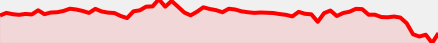
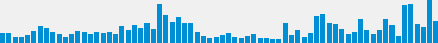
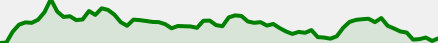
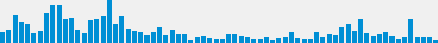
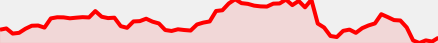
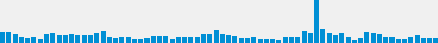
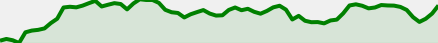
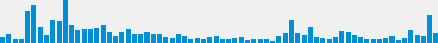
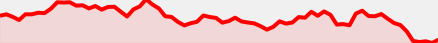
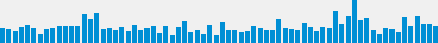
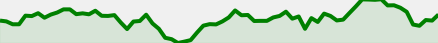
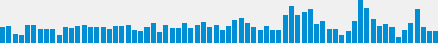
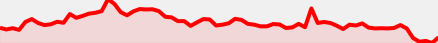
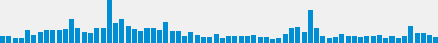
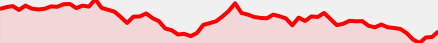
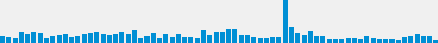
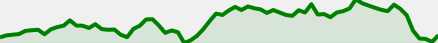
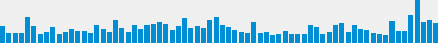
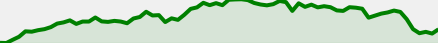
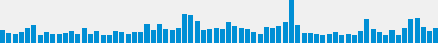
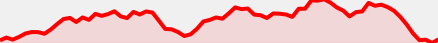
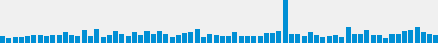
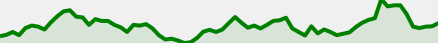
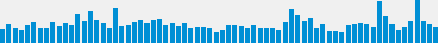
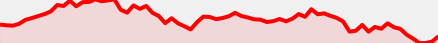
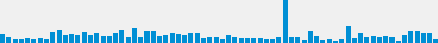
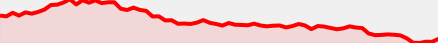
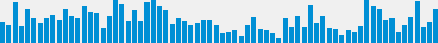
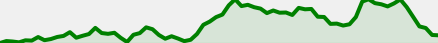
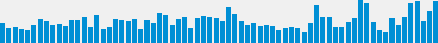
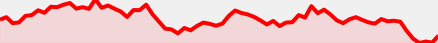
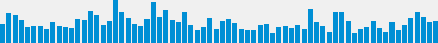
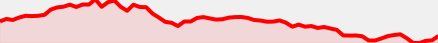
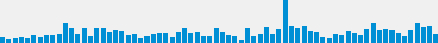
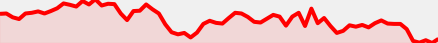
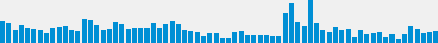
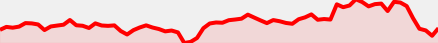
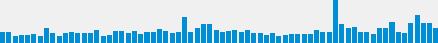
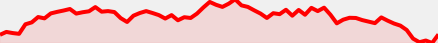
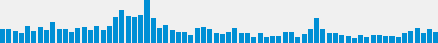
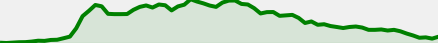
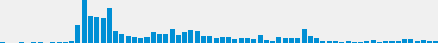
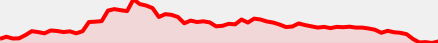
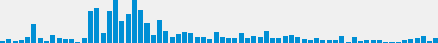
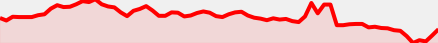
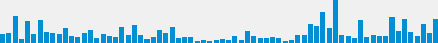
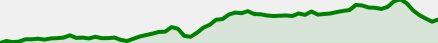
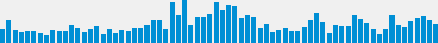
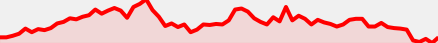
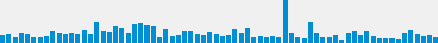
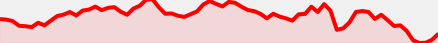
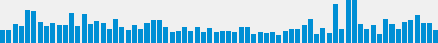
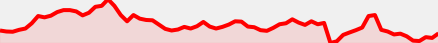
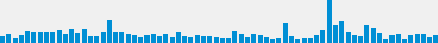
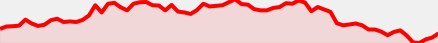
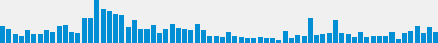
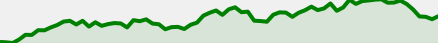
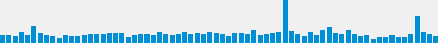
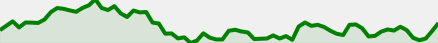
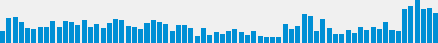
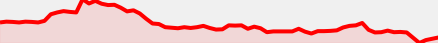
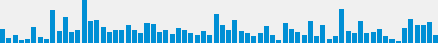
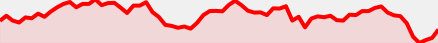
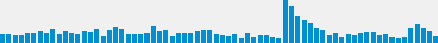
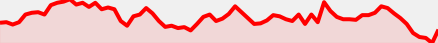
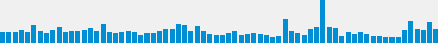
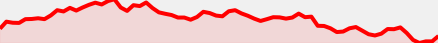
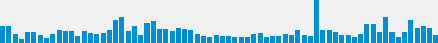
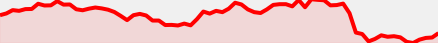
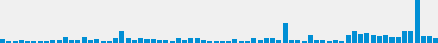
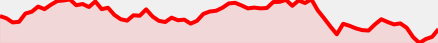
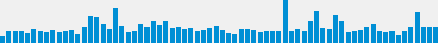
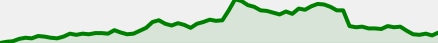
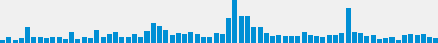
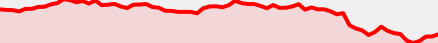
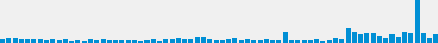
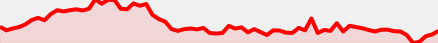
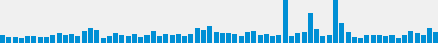
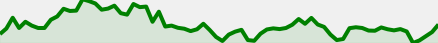
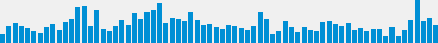
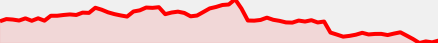
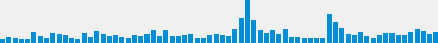
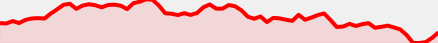
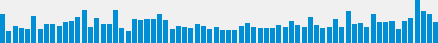
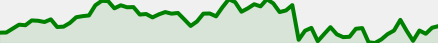
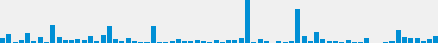
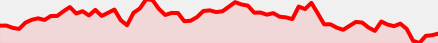
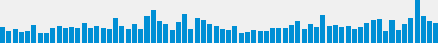
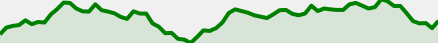
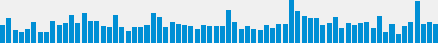
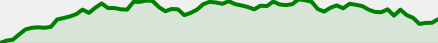
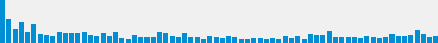
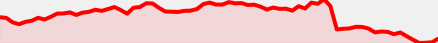
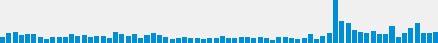
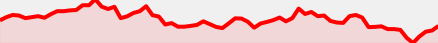
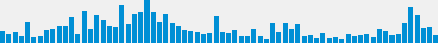
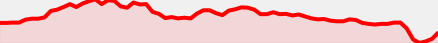
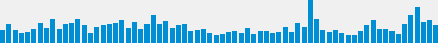
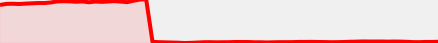
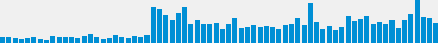
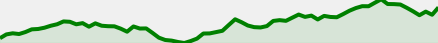
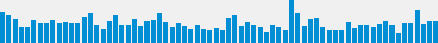
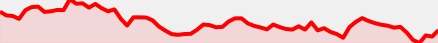
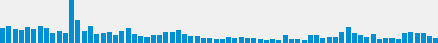
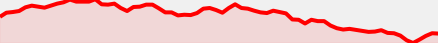
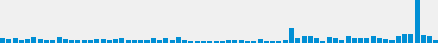
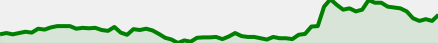
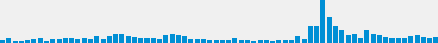
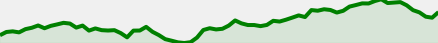
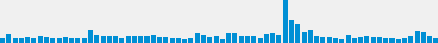
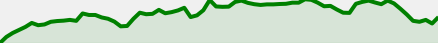
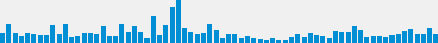
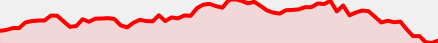
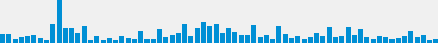
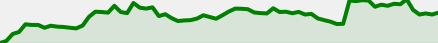
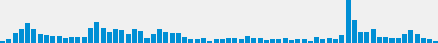
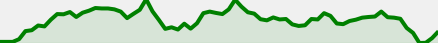
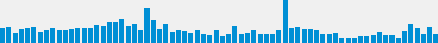
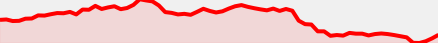
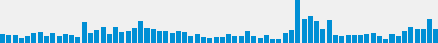
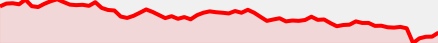
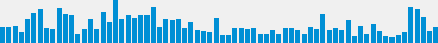
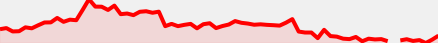
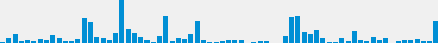
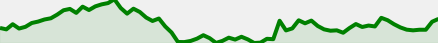
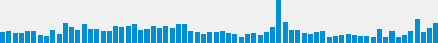
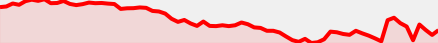
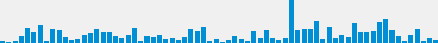

In [10]:
show_table(df =df[df['17SectorName'] =='AUTOMOBILES & TRANSPORTATION EQUIPMENT '], num_of_rows=100)

### AdjustmentFactor & Missing Values
from above table we can clearly see that sudden decreass in price and increas in volume TOYOTA MOTOR CORPORATION stock, this randomness in movement is due to stock splitting, Dividend

Adjusted prices are essential when working with historical stock prices. Any time there is a corporate split or dividend, all stock prices prior to that event need to be adjusted to reflect the change.

In [11]:
def calculate_adjusted_prices(df_security):
    
    # fill missing values
    df_security.fillna(method='ffill', inplace=True)
    
    df_security[['Open', 'High', 'Low', 'Close']]= df_security[['Open', 'High', 'Low', 'Close']]\
        .multiply(
            df_security.AdjustmentFactor.sort_index(ascending=False)\
                .cumprod()\
                .sort_index(ascending=True), 
            axis=0)
    return df_security


def plot_close(df, securities_to_plot, ax=None, name=None, figsize= None):
    df.loc[df.SecuritiesCode.isin(securities_to_plot)].pivot_table(columns= 'Date', index=['SecuritiesCode', 'Name']).Close.T.plot(ax=ax, figsize=figsize)
    if name != None: ax.set_title(name, fontdict ={'fontsize': 30})

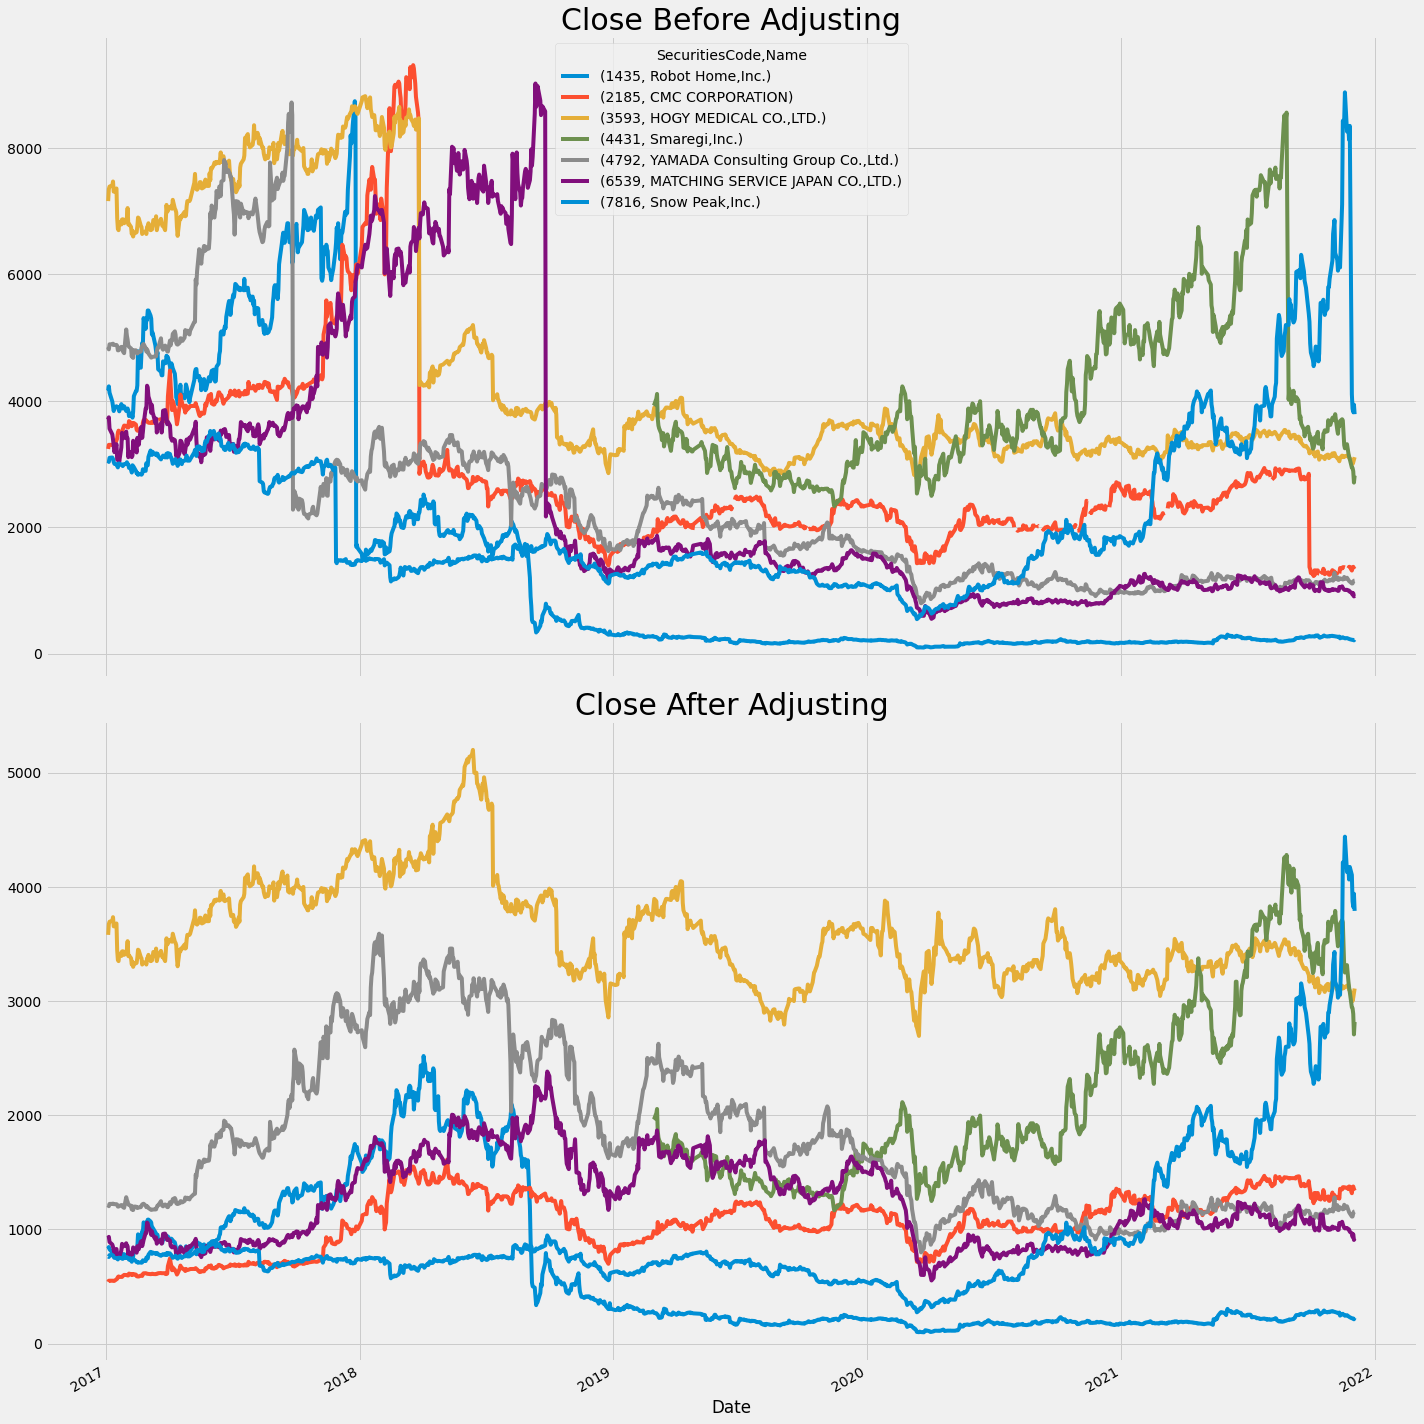

In [12]:
fig, ax = plt.subplots(2,1,figsize=(20,20), sharex=True)

# get 7 SecuritiesCode usefull for plotting
securities_to_plot = df[df.AdjustmentFactor<1].sort_values('Close', ascending = False).SecuritiesCode[70:77].values

# plot close befor adjusting values
plot_close(df, securities_to_plot, ax[0], 'Close Before Adjusting')

# apply adjusting func
df = applyParallel(dfGrouped= df.groupby('SecuritiesCode'), func= calculate_adjusted_prices)

# plot close After adjusting values
plot_close(df, securities_to_plot, ax[1], 'Close After Adjusting')
ax[1].get_legend().remove()

plt.tight_layout()
plt.show()

### Normalization
Normalizing time series data is benefitial when we want to compare multiple time series/stock price trends. to normalized data we divide security values with startig values.

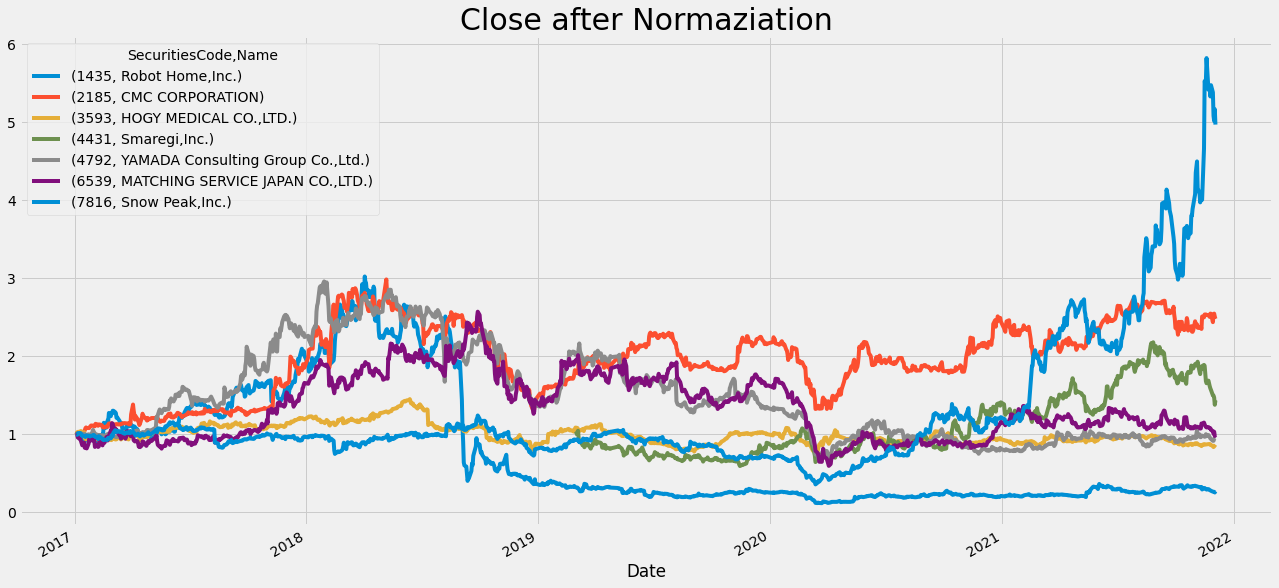

In [13]:
def normalizer(df_security):
    # get first nonNull close value as Face Value
    face_value= df_security.loc[df_security.first_valid_index()].Close
    
    # Divide each feature by Face value
    df_security[['Open', 'High', 'Low', 'Close', 'Volume']] = df_security[['Open', 'High', 'Low', 'Close', 'Volume']] / face_value
    return df_security

df= applyParallel(dfGrouped= df.groupby('SecuritiesCode'), func= normalizer)

plot_close(df, securities_to_plot, figsize=(20,10))
plt.title('Close after Normaziation', fontsize= 30)
plt.show()

In [14]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
SecuritiesCode,2332531.0,5.894835e+03,2.404161e+03,1.301000e+03,3.891000e+03,6.238000e+03,7.965000e+03,9.997000e+03
Open,2316892.0,1.317868e+00,1.235764e+00,6.340136e-02,8.974057e-01,1.080658e+00,1.391185e+00,7.584951e+01
High,2316892.0,1.335983e+00,1.263541e+00,7.156463e-02,9.068323e-01,1.092030e+00,1.408840e+00,7.694175e+01
Low,2316892.0,1.299032e+00,1.207513e+00,6.299320e-02,8.871473e-01,1.068966e+00,1.372870e+00,7.390777e+01
Close,2316892.0,1.317587e+00,1.236062e+00,6.925170e-02,8.969697e-01,1.080566e+00,1.390900e+00,7.536408e+01
Volume,2316892.0,7.341404e+02,5.220773e+03,0.000000e+00,1.834852e+01,7.188697e+01,2.899070e+02,1.418414e+06
AdjustmentFactor,2332531.0,1.000508e+00,6.773040e-02,1.000000e-01,1.000000e+00,1.000000e+00,1.000000e+00,2.000000e+01
ExpectedDividend,2205172.0,2.243132e+01,2.982195e+01,0.000000e+00,5.500000e+00,1.500000e+01,3.000000e+01,1.070000e+03
Target,2332293.0,4.450964e-04,2.339879e-02,-5.785414e-01,-1.049869e-02,0.000000e+00,1.053159e-02,1.119512e+00
IssuedShares,2332531.0,1.557134e+08,6.108806e+08,7.800000e+05,1.958800e+07,3.929336e+07,9.814550e+07,1.631499e+10


#### Feature Engineering

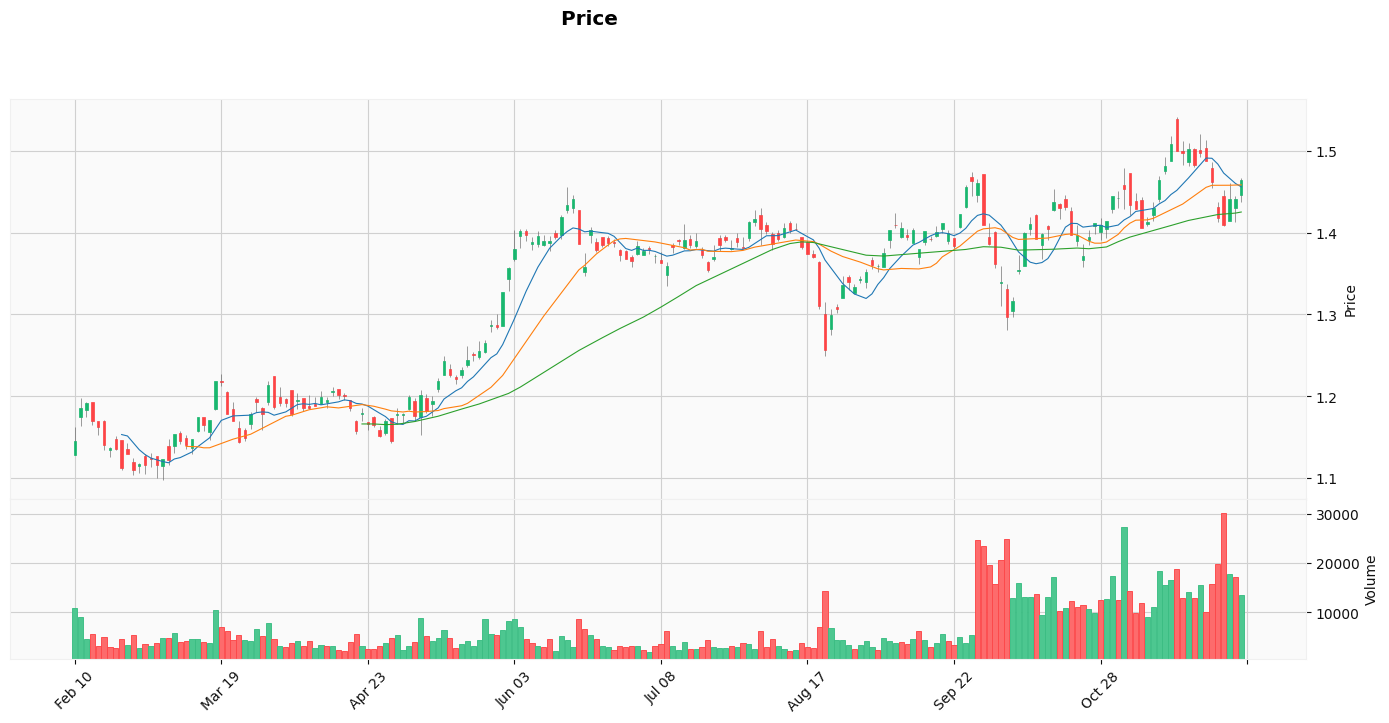

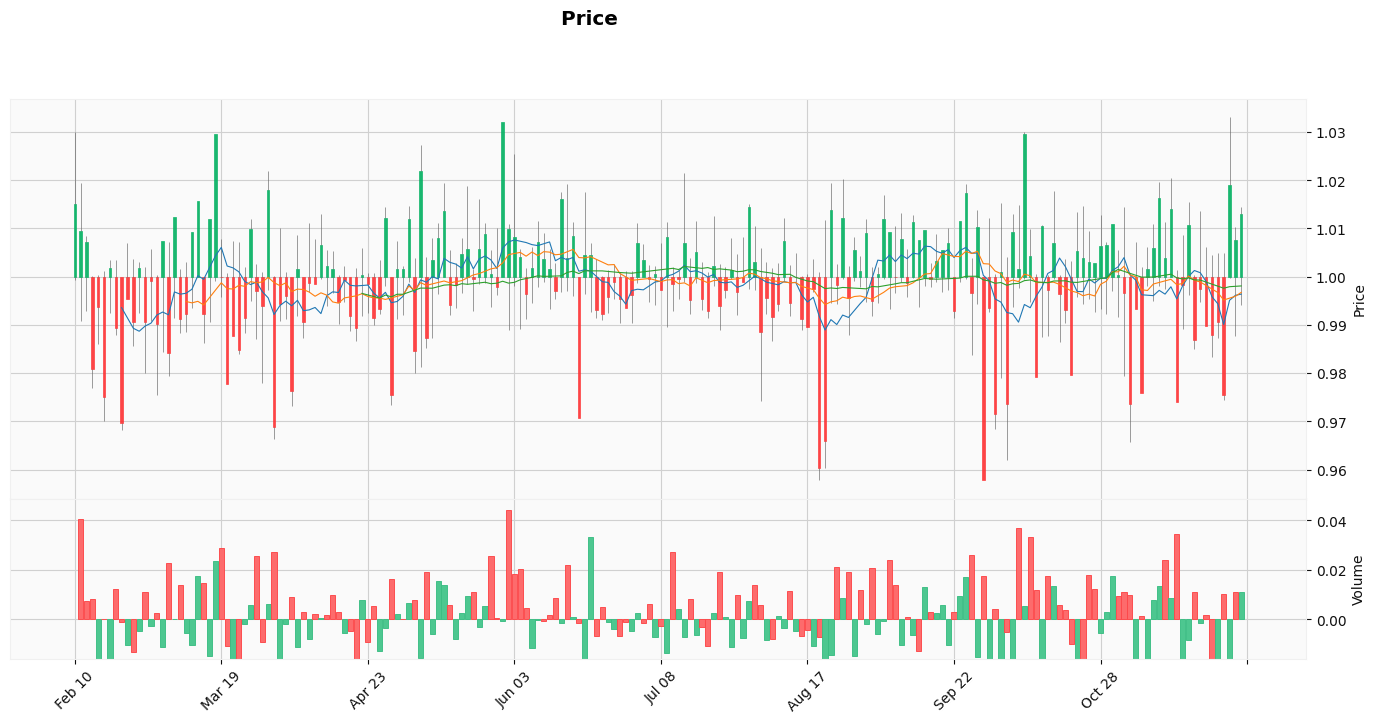

In [15]:
a= df[df.SecuritiesCode==7203].iloc[-200:]
mpl.plot(
    a,
    type="candle",
    volume=True,
    mav =(9,20,50),
    title = f" Price",  
    style='yahoo',
    figsize=(18,8))

a.Volume= a.Open.pct_change()
a[['Open', 'High', 'Low', 'Close']] = a[['Open', 'High', 'Low', 'Close']].divide(a.Open, axis= 0)
#a.Volume =a.Volume.pct_change()

mpl.plot(
    a,
    type="candle",
    volume=True,
    mav =(9,20, 50),
    title = f" Price",  
    style='yahoo',
    figsize=(18,8))

## Optimal Portfolios & the Efficient Frontier

In [16]:
# Loading Stock Returns

usecols = ["Date","SecuritiesCode","Target"]
df = pd.read_csv('/content/drive/MyDrive/JPX_Tokyo_Stock_Exchange_Prediction/data/train_files/stock_prices.csv', usecols=usecols)
df = df[df.Date>"2021-08-01"]
df = df.pivot(index='Date', columns='SecuritiesCode', values='Target')
df = df.fillna(0)

In [17]:
def absHighPass(df, absThresh):
    c = df.columns.values
    a = np.abs(df.values)
    np.fill_diagonal(a, 0)
    i = np.where(a >= absThresh)[0]
    i = sorted(i)
    return df.loc[c[i],c[i]]

def absHigh(df, num):
    c = df.columns.values
    a = np.abs(df.values)
    np.fill_diagonal(a, 0)
    i = (-a).argpartition(num, axis=None)[:num]
    i, _ = np.unravel_index(i, a.shape)
    i = sorted(i)
    return df.loc[c[i],c[i]]

def selLow(df, num):
    c = df.columns.values
    a = df.values
    np.fill_diagonal(a, 0)
    i = (a).argpartition(num, axis=None)[:num]
    i, _ = np.unravel_index(i, a.shape)
    i = sorted(i)
    return df.loc[c[i],c[i]]

corr = df.corr()

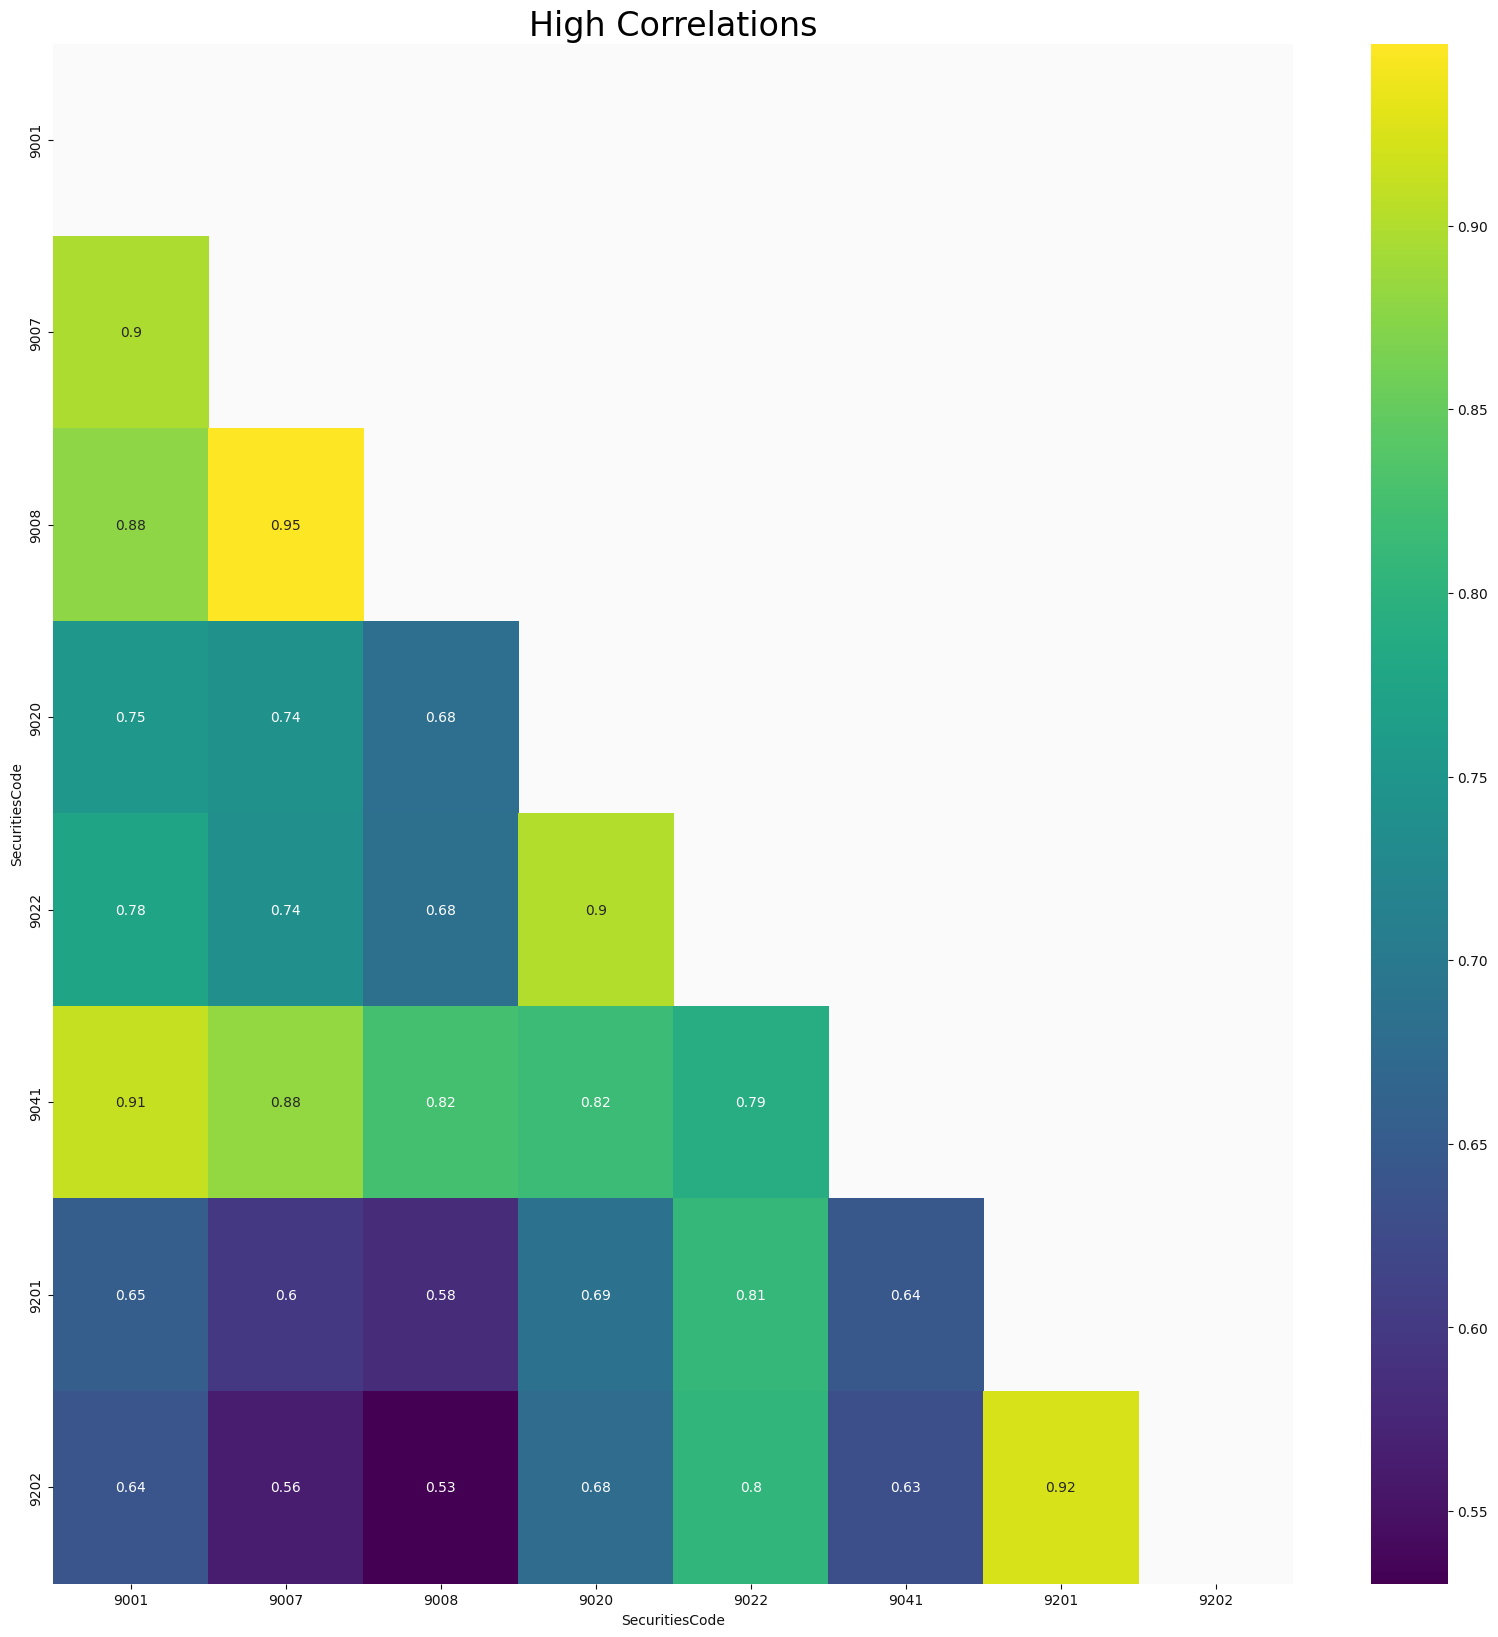

In [18]:
mat = absHigh(corr,8)
mask = np.triu(np.ones_like(mat))
fig, ax = plt.subplots(figsize=(20, 20))
ax.set_title("High Correlations", fontsize = 24)
sns.heatmap(mat, annot=True, mask=mask, cmap="viridis")
plt.show();

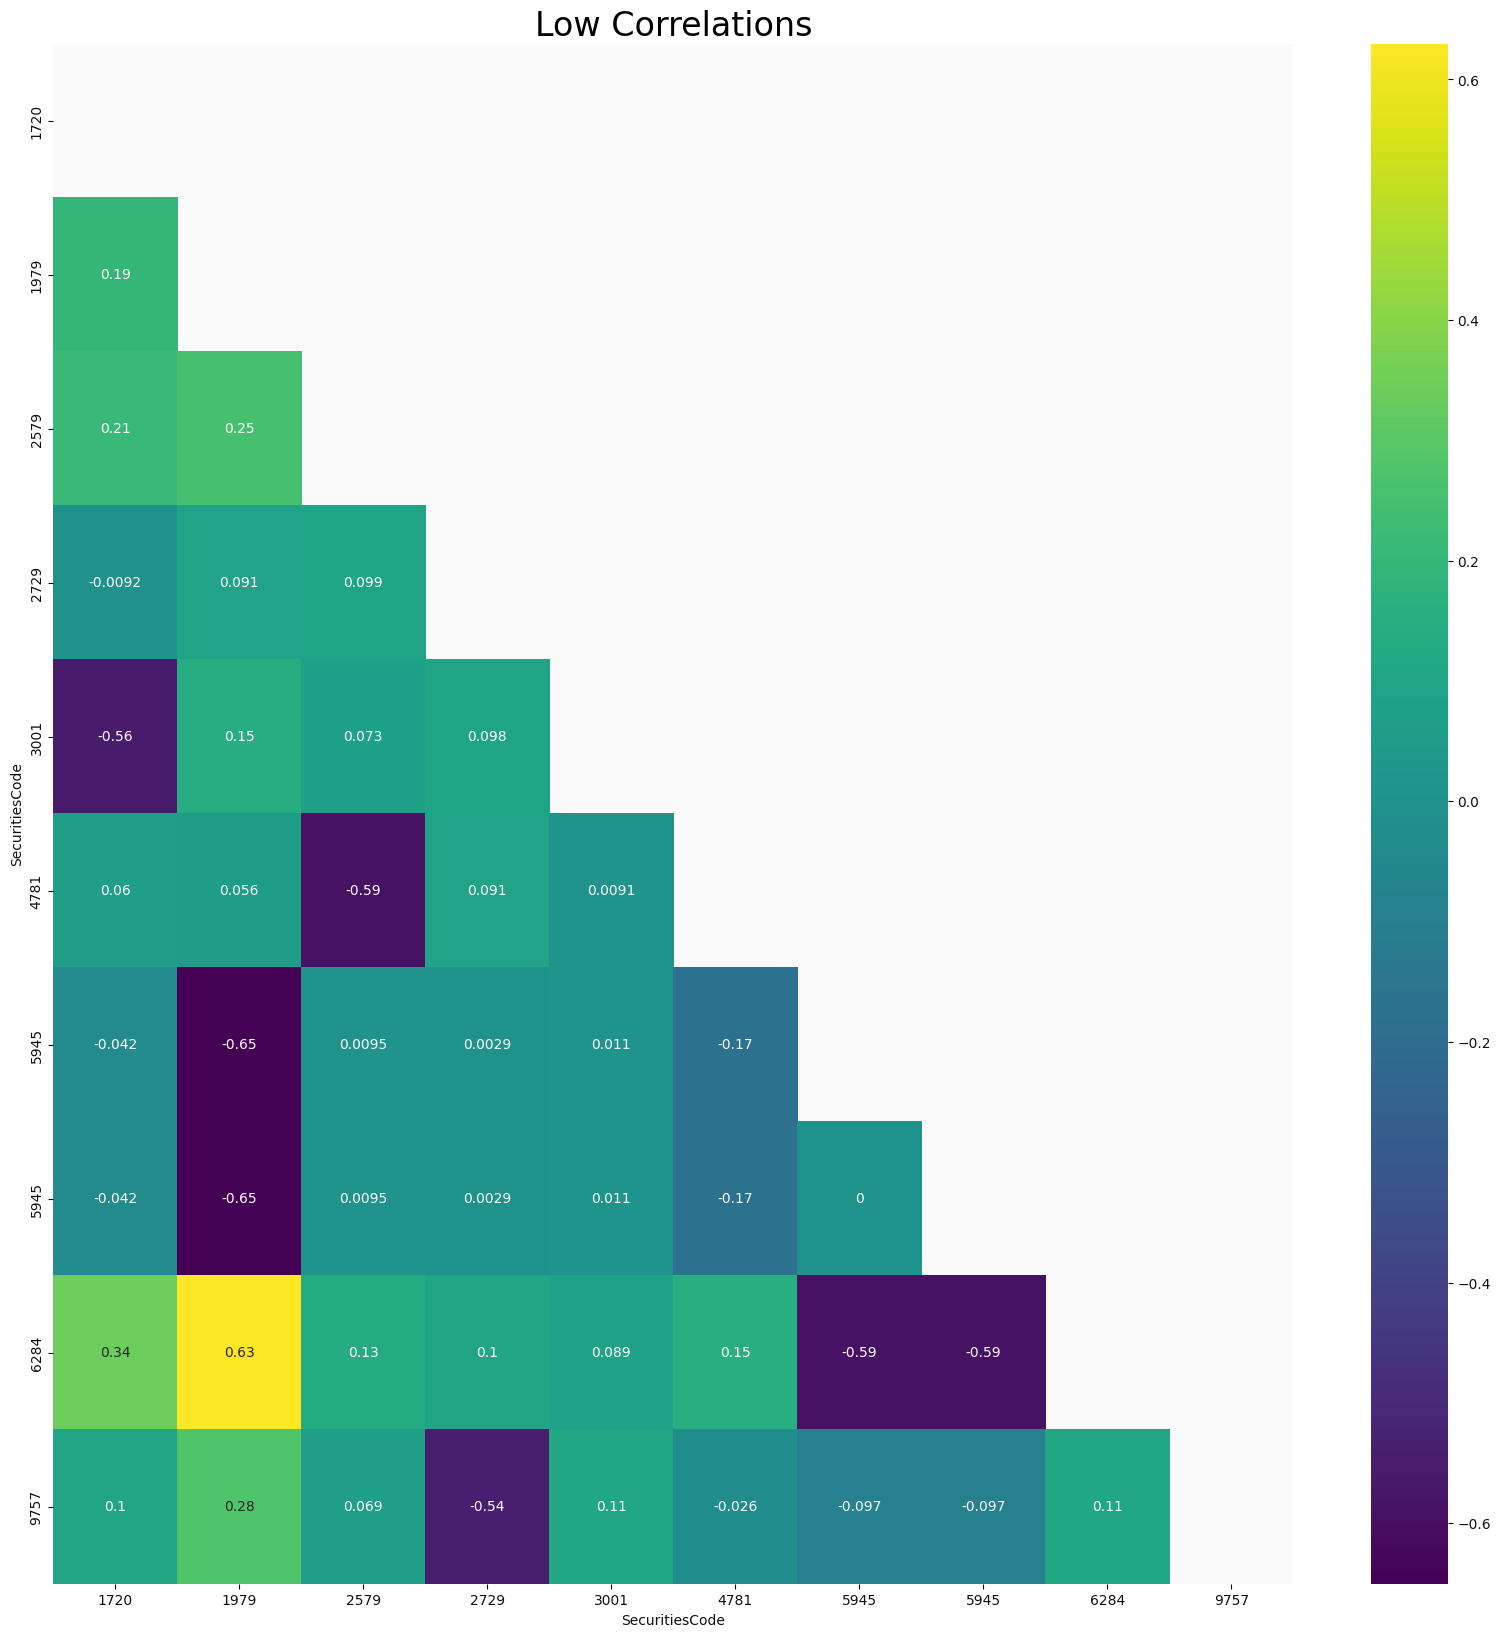

In [19]:
mat = selLow(corr,10)
mask = np.triu(np.ones_like(mat))
fig, ax = plt.subplots(figsize=(20, 20))
ax.set_title("Low Correlations", fontsize = 24)
sns.heatmap(mat, annot=True, mask=mask, cmap="viridis")
plt.show();

#### Calculating the Efficient Frontier

There are 2 inputs we must compute before finding the Efficient Frontier for our stocks: annualized rate of return and covariance matrix.

Annualized rate of return is calculated by multiplying the daily percentage change for all of the stocks with the number of business days each year (252).

In [20]:
# Calculate annualized average return for each asset
# Annualized average return = Daily average return * 252 business days.
ra = np.mean(df,axis=0)*252

# Create a covariance matrix
covar = df.cov()*252

# Calculate annualized volatility for each asset
vols = np.sqrt(np.diagonal(covar))

# Create weights array
weights = np.concatenate([np.linspace(start=2, stop=1, num=200),
                          np.zeros(1600),
                          np.linspace(start=-1, stop=-2, num=200)])

# Calculate Sharpe Ratio for each asset
sr = (ra/vols).reset_index().rename(columns={0: 'SR'})
sr['Rank0'] = sr["SR"].rank(method="first",ascending=False).astype('int')-1
sr = sr.sort_values('Rank0')
sr['weights'] = weights

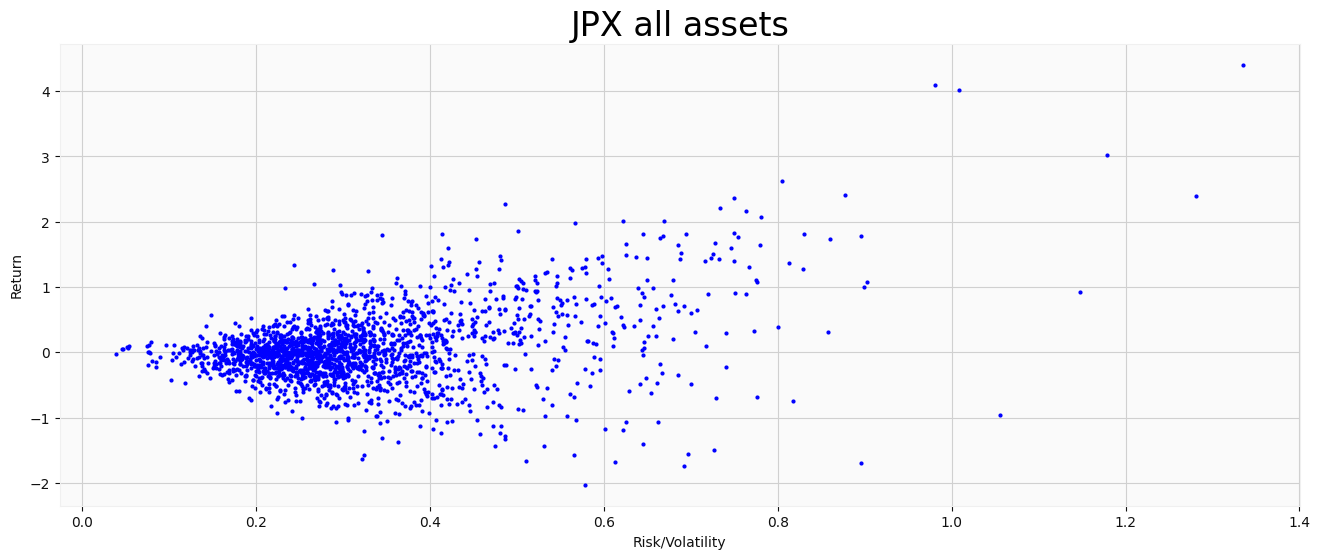

In [21]:
plt.figure(figsize=(16,6))
plt.title('JPX all assets', fontsize=24)
plt.xlabel('Risk/Volatility')
plt.ylabel('Return')
plt.plot(vols, ra,'bo', markersize=2)
plt.show();

##### Top and Botton Sharpe Ratios Assets

In [22]:
#Select Top and Botton Sharpe Ratios
Top200SR = sr.SecuritiesCode.values[:200]
Bot200SR = sr.SecuritiesCode.values[-200:]
Top200SR, Bot200SR

(array([9755, 4825, 7734, 8929, 8358, 4765, 4169, 7809, 9613, 4722, 6411,
        5273, 5384, 7071, 4229, 6881, 2168, 7089, 3843, 6078, 3498, 4837,
        3371, 2181, 6779, 7906, 5757, 7715, 6626, 6875, 6460, 7803, 3844,
        1429, 8508, 4307, 8919, 2412, 7816, 3772, 4507, 6967, 2175, 9612,
        8137, 9824, 7832, 7082, 3765, 6333, 8158, 8114, 8035, 4251, 3675,
        4323, 3774, 6196, 2987, 3465, 1662, 3001, 7512, 4568, 2158, 3431,
        8136, 4704, 6104, 3628, 8806, 7433, 6962, 4980, 2471, 6941, 2801,
        6098, 4021, 4716, 8699, 6430, 5121, 4781, 2802, 4485, 6727, 6841,
        6055, 4661, 2307, 2154, 9716, 7030, 4490, 3676, 6957, 7826, 4483,
        8739, 3580, 6758, 2729, 2395, 5631, 9793, 3632, 9889, 5334, 4880,
        6920, 9267, 8303, 9896, 6191, 9769, 6533, 3865, 5344, 3355, 9107,
        6490, 9086, 6200, 8591, 9308, 4235, 2980, 4689, 8141, 6879, 7095,
        4499, 2379, 4970, 1605, 6645, 4975, 5698, 4771, 7414, 6652, 2491,
        8848, 6089, 4238, 6323, 6815, 

In [23]:
# Covariance matrix annualized of Top and Botton Sharpe Ratios
cov_port = df[np.concatenate([Top200SR,Bot200SR])].cov()*252
# Returns annualized
ret_port = np.mean(df[np.concatenate([Top200SR,Bot200SR])],axis=0)*252

Next, we should define some functions that we will use later in our calculation.

Rate of return is the annualized rate of return for the whole portfolio.
Volatility is the risk level, defined as the standard diviation of return.
Sharpe ratio is risk efficiency; it assesses the return of an investment compared to its risk.

In [24]:

from numba import jit

# Rate of return
@jit(forceobj=True)
def ret(r,w):
    return r.dot(w)

# Risk level or volatility
@jit(forceobj=True)
def vol(w,c):
    return np.sqrt(np.dot(w,np.dot(w,c)))

@jit(forceobj=True)
def sample_opt(c, r, w):
    # Round Expected volatility
    _vi = int(vol(w, c)*1e5)/1e5
    # Round Expected return
    _ri = int(ret(r, w)*1e4)/1e4
    return (_vi,_ri)

#### Optimizing Risk and Sharpe Ratio

In [25]:
%%time

#Create x0, the first guess at the values of each asset's weight.
w0 = np.linspace(start=1, stop=0, num=cov_port.shape[1])
x0 = w0/np.sum(w0)
# All weights between 0 and 1
bounds = Bounds(0, 1)
# The second boundary is the sum of weights.
linear_constraint = LinearConstraint(np.ones((cov_port.shape[1],), dtype=int),1,1)
options = {'xtol': 1e-07, 'gtol': 1e-07, 'barrier_tol': 1e-07, 'maxiter': 1000}

# Find a portfolio with the minimum risk.
def min_risk(_cov):  
    #Define a function to calculate volatility
    fvol = lambda w: np.sqrt(np.dot(w,np.dot(w,_cov)))
    res = minimize(fvol,x0,method='trust-constr', 
                   constraints=linear_constraint, 
                   bounds=bounds)
    return res.x

# Find a portfolio with the highest Sharpe Ratio.
def max_sr(_ret,_cov):
    #Define 1/Sharpe_ratio
    isharpe = lambda w: np.sqrt(np.dot(w,np.dot(w,_cov)))/_ret.dot(w)
    res = minimize(isharpe,x0,method='trust-constr',
                          constraints = linear_constraint,
                          bounds = bounds,
                          options = options)
    return res.x
 

#These are the weights of the assets in the portfolio with the lowest level of risk possible.
w_minr = min_risk(cov_port)
opt_risk_ret = ret(ret_port,w_minr)
opt_risk_vol = vol(w_minr,cov_port)
print(f'Min. Risk = {opt_risk_vol*100:.3f}% => Return: {(opt_risk_ret*100):.3f}%  Sharpe Ratio = {opt_risk_ret/opt_risk_vol:.2f}')

#These are the weights of the assets in the portfolio with the highest Sharpe ratio.
w_sr_top = max_sr(ret_port,cov_port)
opt_sr_ret = ret(ret_port,w_sr_top)
opt_sr_vol = vol(w_sr_top,cov_port)
print(f'Max. Sharpe Ratio = {opt_sr_ret/opt_sr_vol:.2f} => Return: {(opt_sr_ret*100):.2f}%  Risk: {opt_sr_vol*100:.3f}%')

Min. Risk = 2.780% => Return: -11.347%  Sharpe Ratio = -4.08
Max. Sharpe Ratio = 13.37 => Return: 123.21%  Risk: 9.216%
CPU times: user 2min 38s, sys: 1min 27s, total: 4min 6s
Wall time: 2min 7s


In [26]:
%%time

# Efficient Frontier Optimizer

frontier_y = np.linspace(-1.4, opt_sr_ret*1.4, 50)
frontier_x = []
sr_opt_set = set()

x0 = w_sr_top
bounds = Bounds(0, 1)

@jit(forceobj=True)
def callbackF(w):
    global sr_opt_set, ret_port, cov_port
    sr_opt_set.add( sample_opt(cov_port, ret_port, w) )

@jit(forceobj=True)
def check_sum(w):
    #return 0 if sum of the weights is 1
    return np.sum(w)-1

for possible_return in frontier_y:
    cons = ({'type':'eq', 'fun': check_sum},
            {'type':'eq', 'fun': lambda w: ret(ret_port, w) - possible_return})

    #Define a function to calculate volatility
    fun = lambda w: np.sqrt(np.dot(w,np.dot(w,cov_port)))
    result = minimize(fun,x0,method='SLSQP', bounds=bounds, constraints=cons, callback=callbackF)
    frontier_x.append(result['fun'])

frontier_x = np.array(frontier_x)
dt_plot = pd.DataFrame(sr_opt_set, columns=['vol', 'ret'])
vol_opt = dt_plot['vol'].values
ret_opt = dt_plot['ret'].values
sharpe_opt = ret_opt/vol_opt

CPU times: user 7min 48s, sys: 2min 21s, total: 10min 10s
Wall time: 7min 36s


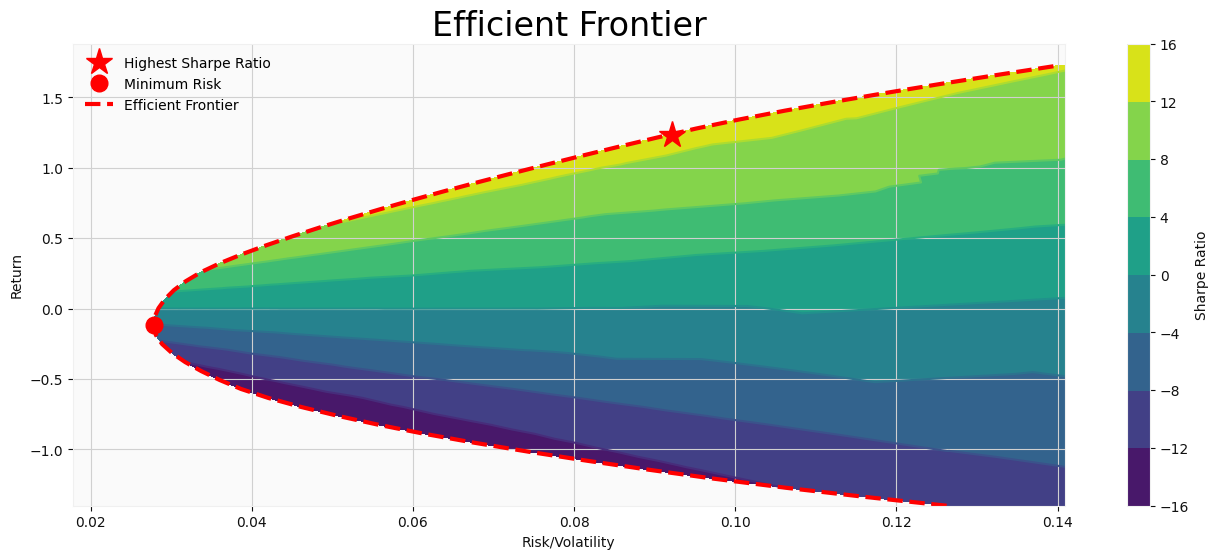

In [27]:
# Plot Efficient Frontier

triang = tri.Triangulation(vol_opt, ret_opt)
triang.set_mask(np.hypot(vol_opt[triang.triangles].mean(axis=1),
                         ret_opt[triang.triangles].mean(axis=1))<-1)

fig1 = plt.figure(figsize=(16,6))
ax1 = fig1.add_subplot(111)
tcf = ax1.tricontourf(triang, sharpe_opt)
fig1.colorbar(tcf, label='Sharpe Ratio')
ax1.tricontour(triang, sharpe_opt, colors=None)
plt.xlim([frontier_x.min()-0.01,frontier_x.max()+0.001])
plt.title('Efficient Frontier', fontsize=24)
plt.xlabel('Risk/Volatility')
plt.ylabel('Return')
plt.plot(opt_sr_vol, opt_sr_ret,'r*', markersize=20, label='Highest Sharpe Ratio') # red star
plt.plot(opt_risk_vol,  opt_risk_ret, 'ro', markersize=12, label='Minimum Risk') # red dot
plt.plot(frontier_x, frontier_y, 'r--', linewidth=3, label='Efficient Frontier') # red dashed line
plt.legend(loc="upper left", frameon=False)
plt.show();

Optimize Sharpe Ratio for Top and Botton Assets

In [28]:
%%time

# Optimize Sharpe Ratio for Top and Botton Assets

# Covariance matrix annualized of Sharpe Ratios
cov_port = df[np.concatenate([Top200SR,Bot200SR])].cov()*252
# Returns annualized
ret_port = np.mean(df[np.concatenate([Top200SR,Bot200SR])],axis=0)*252

#Create x0, the first guess at the values of each asset's weight.
x0 = np.linspace(start=1, stop=-1, num=cov_port.shape[1])

# All weights between -1 and 1
bounds = Bounds(-1, 1)

# The second boundary is the sum of weights.
linear_constraint = LinearConstraint(np.ones((cov_port.shape[1],), dtype=int),0,0)

#These are the weights of the asset in the portfolio.
w_sr_port = max_sr(ret_port,cov_port)
w_sr_all = np.concatenate([w_sr_port[:200],np.ones(1600)*np.abs(w_sr_port).min(), w_sr_port[-200:]])
opt_ret = ret(ret_port,w_sr_port)
opt_vol = vol(w_sr_port,cov_port)
print(f'Sharpe Ratio = {opt_ret/opt_vol:.2f} Risk = {opt_vol*100:.7f}% => Return: {(opt_ret*100):.3f}%')

Sharpe Ratio = 358982805.54 Risk = 0.0000087% => Return: 3127.282%
CPU times: user 1min 36s, sys: 1min 14s, total: 2min 51s
Wall time: 1min 28s


Save Results

In [29]:
sr['w_opt'] = w_sr_all
sr = sr.sort_values('SecuritiesCode')
sr['Target'] = ra.values*sr['w_opt']
sr['Rank'] = sr['w_opt'].rank(method='first',ascending=False).astype('int')-1
rank = sr.set_index('SecuritiesCode')['Rank'].to_dict()
trgt = sr.set_index('SecuritiesCode')['Target'].to_dict()
sr.to_csv("sharpe_ratio_opt.csv")